In [1]:
import os, sys
print("CWD:", os.getcwd())
print("NumPy path:", __import__("numpy").__file__)

CWD: /Users/utkarshsingh/QML/QSVM/Maicon_kernel/qnn_codebase_v2/examples
NumPy path: /Users/utkarshsingh/miniforge3/envs/qml/lib/python3.11/site-packages/numpy/__init__.py


In [2]:
import sys
PKG_DIR = "/Users/utkarshsingh/QML/QSVM/Maicon_kernel/qnn_codebase_v2/"  # <- change me
sys.path.append(PKG_DIR)

In [3]:
# experiments/run_cls_estimator.py
import numpy as np
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA
from qnn.circuits.qnn_circuit import build_qnn_raw, build_qnn_for_runtime
from qnn.primitives.factory import make_estimator
from qnn.networks.estimator_qnn import make_estimator_qnn
from qnn.models.classifier import make_classifier
from qnn.training.callbacks import LiveObjectivePlot

In [8]:
# examples/torch_binary_easy.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from qnn.torch.easy_torch import QNNTorchEstimator, TorchQNNConfig

# toy data
rng = np.random.default_rng(0)
X = 2*rng.random((50, 2)) - 1
y01 = (X[:,0] * X[:,1] > 0).astype(np.float32)  # XOR-ish
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y01, dtype=torch.float32).unsqueeze(-1)

model = QNNTorchEstimator(TorchQNNConfig(
    num_inputs=2,
    mode="noisy_simulation",   # or "simulation"
))

criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.05)

for epoch in range(10):
    print(epoch)
    opt.zero_grad()
    logits = model(X_t) * 2.5        # scale expectation [-1,1] to logits
    loss = criterion(logits, y_t)
    loss.backward()
    opt.step()

with torch.no_grad():
    preds = (torch.sigmoid(model(X_t)*2.5) > 0.5).float()
    acc = (preds.eq(y_t).float().mean()).item()
print("torch acc:", acc)

0
1
2
3
4
5
6
7
8
9
torch acc: 0.7599999904632568


In [9]:
import numpy as np, torch
import torch.nn as nn, torch.optim as optim
from qnn.torch.easy_torch import QNNTorchEstimator, TorchQNNConfig

# toy data
rng = np.random.default_rng(0)
X = 2*rng.random((50, 2)) - 1
y01 = (X[:,0]*X[:,1] > 0).astype(np.float32)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y01, dtype=torch.float32).unsqueeze(-1)

# Estimator path (noisy or clean)
model = QNNTorchEstimator(TorchQNNConfig(
    num_inputs=2,
    mode="simulation",          # or "noisy_simulation"
    dtype=torch.float32,
))

criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=0.05)

for e in range(10):
    print(e)
    opt.zero_grad()
    logits = model(X_t) * 2.5
    loss = criterion(logits, y_t)
    loss.backward()
    opt.step()

with torch.no_grad():
    preds = (torch.sigmoid(model(X_t)*2.5) > 0.5).float()
    acc = (preds.eq(y_t).float().mean()).item()
print("torch acc:", acc)

0
1
2
3
4
5
6
7
8
9
torch acc: 0.7799999713897705


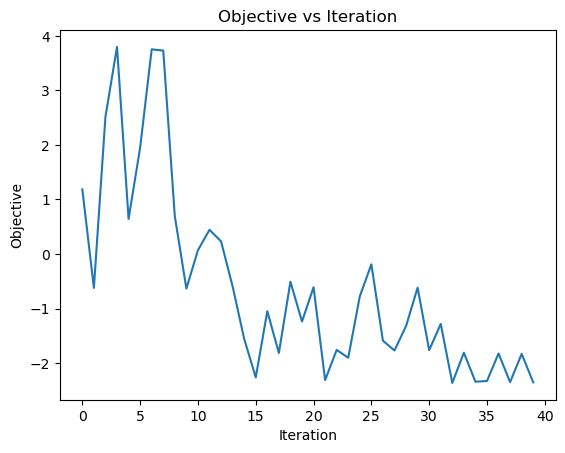

acc (sim): 0.62


In [10]:
import numpy as np
from qnn.easy import QNNEasyClassifier

# toy data
X = 2*np.random.rand(50, 2) - 1
y = (X[:,0] + X[:,1] > 0).astype(int) * 2 - 1  # {-1,+1}

# 1) Plain simulation (no noise)
clf = QNNEasyClassifier(mode="simulation")
clf.fit(X, y)
print("acc (sim):", clf.score(X, y))

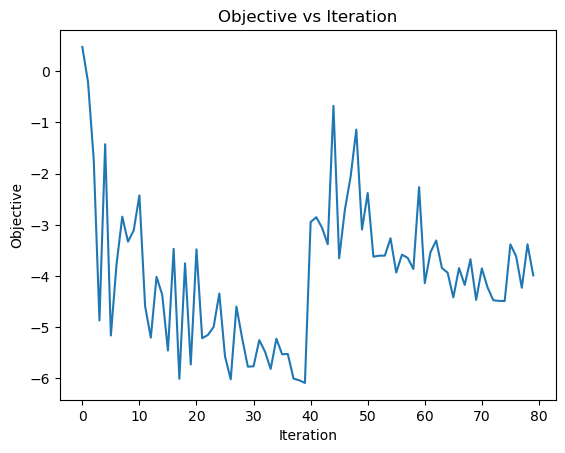

acc (noisy): 0.6


In [5]:
# 2) Noisy simulation (fake device noise; no account needed)
clf2 = QNNEasyClassifier(mode="noisy_simulation")
clf2.fit(X, y)
print("acc (noisy):", clf2.score(X, y))

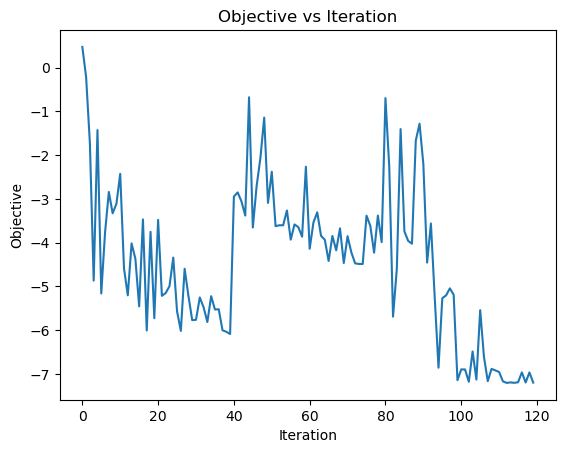

acc (noisy): 0.69


In [6]:
# Pass your own primitive (estimator or sampler)
from qiskit_aer.primitives import EstimatorV2
my_est = EstimatorV2(options={"run_options":{"shots":4096}})
clf = QNNEasyClassifier(mode="simulation", primitive=my_est)
clf.fit(X, y)
print("acc (noisy):", clf.score(X, y))

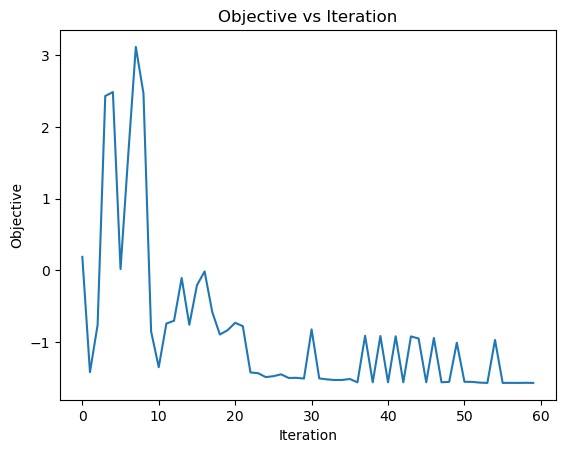

train accuracy: 0.575


In [5]:
# 0) reproducibility
algorithm_globals.random_seed = 42

# 1) toy dataset (same spirit as tutorial)
num_inputs, num_samples = 2, 40
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = (np.sum(X, axis=1) >= 0).astype(int)      # {0,1}
y = 2 * y01 - 1                                  # {-1,+1} for EstimatorQNN classifier

# 2) circuit & primitive
qc, in_pr, out_pr = build_qnn_raw(num_qubits=num_inputs)     # default ZZFeatureMap + RealAmplitudes
estimator = make_estimator("statevector")

# 3) QNN & model
qnn = make_estimator_qnn(qc, estimator=estimator)#, input_params=in_pr, weight_params=out_pr)
callback = LiveObjectivePlot()
clf = make_classifier(qnn, optimizer=COBYLA(maxiter=60), callback=callback)

# 4) train & eval
clf.fit(X, y)
print("train accuracy:", clf.score(X, y))


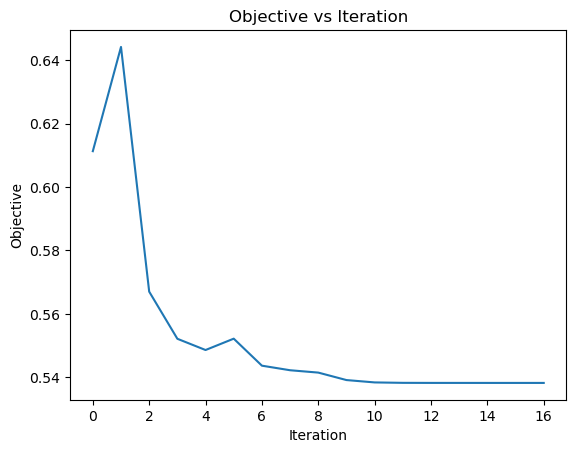

train MSE: 0.6606375089372228


In [6]:
from qiskit_machine_learning.optimizers import L_BFGS_B
from qnn.models.regressor import make_regressor
from qnn.training.callbacks import LiveObjectivePlot

algorithm_globals.random_seed = 42

# y in [-1,1] for a simple illustrative target
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y = np.sin(np.pi * X[:, 0])

qc, in_pr, out_pr = build_qnn_raw(num_qubits=num_inputs)
estimator = make_estimator("statevector")
qnn = make_estimator_qnn(qc, estimator=estimator)#, input_params=in_pr, weight_params=out_pr)

callback = LiveObjectivePlot()
reg = make_regressor(qnn, optimizer=L_BFGS_B(maxiter=20), loss="squared_error", callback=callback)
reg.fit(X, y)
print("train MSE:", np.mean((reg.predict(X) - y)**2))


In [7]:
import numpy as np
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA
from qnn.circuits.qnn_circuit import build_qnn_for_aer
from qnn.networks.estimator_qnn import make_estimator_qnn
from qnn.models.classifier import make_classifier
from qnn.primitives.factory import make_estimator
from qnn.primitives.noise import basic_depolarizing_noise

algorithm_globals.random_seed = 42

num_inputs, num_samples = 2, 80
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = (np.sum(X, axis=1) >= 0).astype(int)
y = 2*y01 - 1

qc, in_params, wt_params = build_qnn_for_aer(
    num_qubits=num_inputs,
    optimization_level=1,
    method="automatic",
)

noise_model = basic_depolarizing_noise(1e-3, 1e-2)
estimator = make_estimator("aer", options={
    "shots": 4096,
    "seed": 42,
    "noise_model": noise_model,     # will be mapped to backend_options
})

qnn = make_estimator_qnn(qc, estimator=estimator, input_params=in_params, weight_params=wt_params)
clf = make_classifier(qnn, optimizer=COBYLA(maxiter=80))
clf.fit(X, y)
print("train accuracy (noisy Aer):", clf.score(X, y))

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


train accuracy (noisy Aer): 0.6125


In [ ]:
import numpy as np
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_ibm_runtime import QiskitRuntimeService

from qnn.circuits.qnn_circuit import build_qnn_for_runtime
from qnn.primitives.runtime import make_runtime_estimator
from qnn.primitives.factory import make_estimator
from qnn.networks.estimator_qnn import make_estimator_qnn
from qnn.models.classifier import make_classifier

# --- toy data
algorithm_globals.random_seed = 42
X = 2 * algorithm_globals.random.random([10, 2]) - 1
y01 = (np.sum(X, axis=1) >= 0).astype(int)
y = 2*y01 - 1
num_inputs = X.shape[1]

service = QiskitRuntimeService()
backend = service.backend("ibm_torino")  # pick your backend

# --- transpile *to backend ISA* so no 'u3' remains
qc, in_params, wt_params = build_qnn_for_runtime(
    num_qubits=num_inputs,
    backend=backend,            # <--- IMPORTANT
    optimization_level=1,
    decompose=False,
)

# --- Open Plan: job mode primitive
est_rt, session = make_runtime_estimator(service=service, 
    backend_name=backend.name,
    shots=1024,
    resilience_level=1,
    execution_mode="job",       
)

estimator = make_estimator("runtime", runtime_estimator=est_rt)

qnn = make_estimator_qnn(
    qc,
    estimator=estimator,
    input_params=in_params,
    weight_params=wt_params,
)

clf = make_classifier(qnn, optimizer=COBYLA(maxiter=2))
clf.fit(X, y)
print("train accuracy (runtime job mode):", clf.score(X, y))

In [4]:
import numpy as np
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA

from qnn.circuits.qnn_circuit import build_qnn_for_aer
from qnn.execution.executor import QNNExecutor, ExecutorConfig
from qnn.networks.estimator_qnn import make_estimator_qnn
from qnn.models.classifier import make_classifier

algorithm_globals.random_seed = 42
X = 2 * algorithm_globals.random.random([60, 2]) - 1
y01 = (np.sum(X, axis=1) >= 0).astype(int)
y = 2*y01 - 1

# executor configured like your QuantumExecutor (sim/noise/shots/opt level)
exe = QNNExecutor(ExecutorConfig(
    mode="aer",
    shots=4096,
    seed=42,
    noise={"p1":1e-3, "p2":1e-2},
    optimization_level=1,
    n_jobs=1,
    cache_path="qnn_estimator_cache.pkl",   # optional on-disk cache
))

# circuit + PM
qc, in_params, wt_params = build_qnn_for_aer(
    num_qubits=X.shape[1],
    optimization_level=exe.cfg.optimization_level,
    method="automatic",
)
pm = exe.make_pass_manager()

# estimator + QNN with pass_manager injected
estimator = exe.make_estimator()
qnn = make_estimator_qnn(qc, estimator=estimator, input_params=in_params, weight_params=wt_params, pass_manager=pm)

clf = make_classifier(qnn, optimizer=COBYLA(maxiter=40))
clf.fit(X, y)
print("train acc:", clf.score(X, y))


train acc: 0.6


In [13]:
from qnn.primitives.fake_device import noise_model_from_fake
from qnn.execution.executor import QNNExecutor, ExecutorConfig

exe = QNNExecutor(ExecutorConfig(
    mode="aer",
    shots=4096,
    seed=42,
    noise_mode="custom",                     # we’ll provide a prebuilt model
    noise_model=noise_model_from_fake("oslo")  # accepts 'oslo', 'fake_oslo', 'FakeOslo'
))

In [7]:
import numpy as np
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

from qnn.circuits.qnn_circuit import build_qnn_for_aer
from qnn.networks.estimator_qnn import make_estimator_qnn
from qnn.models.classifier import make_classifier
from qnn.primitives.fake_device import noise_model_from_fake

# toy data
algorithm_globals.random_seed = 7
X = 2 * np.random.rand(80, 2) - 1
y01 = (np.sum(X, axis=1) >= 0).astype(int)
y = 2*y01 - 1  # {-1, +1}

# circuit transpiled for Aer
qc, in_params, wt_params = build_qnn_for_aer(num_qubits=X.shape[1], optimization_level=1)

# fake device noise (no service)
nm = noise_model_from_fake("oslo")

# Aer V2 estimator with noise + shots/seed
estimator = AerEstimatorV2(options={
    "backend_options": {"noise_model": nm},
    "run_options": {"shots": 4096, "seed": 42},
})

# QNN + scikit-style classifier
qnn = make_estimator_qnn(qc, estimator=estimator, input_params=in_params, weight_params=wt_params, pass_manager=None)
clf = make_classifier(qnn, optimizer=COBYLA(maxiter=40))
clf.fit(X, y)
print("train acc (fake device noise):", clf.score(X, y))

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


train acc (fake device noise): 0.6125
